# **Changing to transfer learning with Mobile Net V3 Small**

From the previous model, we have swapped out the model for Mobile Net V3 Small that has been pretrained and tweaking it to use our data and classes.

Validation Loss: 1.2289
Validation Accuracy: 85.76%
FLOPS: 0.03G

In [223]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2023
### Student Name: Nathaniel Chang, Tommy Hick
### Student ID: a1821595, a1825267
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC: 93.44% FLOPs: 0.03G
##################################################################################################################################

In [224]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [225]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = './animal/dataset/dataset/'
classes = os.listdir(data_dir)

In [226]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),  # Randomly resize and crop the image
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with probability
        transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip with probability
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])


In [227]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [228]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [229]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  ailurus-fulgens (5)


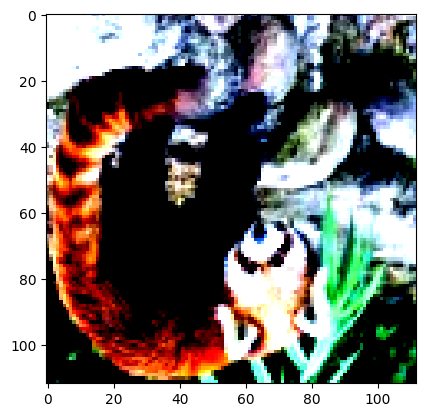

In [230]:
show_image(*dataset[200])

In [231]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [232]:
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [233]:
batch_size = 8
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


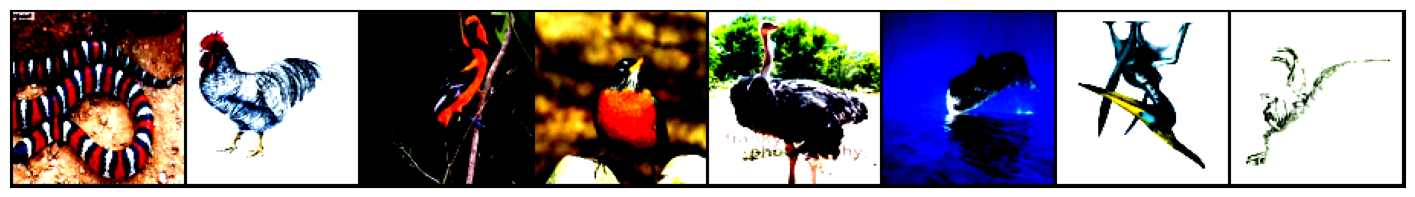

In [234]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [235]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [236]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [237]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [238]:
input_size = 3*112*112
output_size = 151

In [239]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes = classes

        self.model = models.mobilenet_v3_small(pretrained=True)

        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, self.num_classes)

    def forward(self, X):
        X = self.model(X)
        return F.log_softmax(X, dim=1)

In [240]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model.cuda()

ConvolutionalNetwork(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2

In [241]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([8, 3, 112, 112])
out.shape: torch.Size([8, 151])
out[0]: tensor([-5.5542, -5.6103, -5.4379, -5.2414, -5.1411, -4.6883, -4.7928, -4.9843,
        -4.9865, -5.5290, -4.4779, -5.4457, -5.3733, -4.3677, -5.6185, -5.5864,
        -4.5083, -5.0144, -4.3929, -4.8658, -4.8815, -5.8586, -4.5566, -5.1401,
        -4.9144, -5.6852, -5.5693, -5.1761, -5.0683, -5.5963, -5.0061, -4.9665,
        -5.8103, -4.6418, -5.4931, -4.1183, -4.8317, -4.8607, -5.1162, -4.8572,
        -5.9464, -4.8994, -4.7951, -4.9792, -4.8258, -5.0329, -5.0679, -5.1438,
        -5.2102, -5.3552, -4.8719, -5.9381, -5.1105, -5.4190, -5.4374, -5.0009,
        -5.0370, -5.5993, -5.2528, -4.5962, -6.0117, -5.0390, -4.9475, -4.4735,
        -5.4557, -4.3037, -5.4275, -5.0196, -5.1799, -6.4949, -4.8761, -5.4855,
        -4.9137, -4.8761, -5.1473, -5.3224, -4.8004, -4.7817, -5.6682, -6.2449,
        -4.9177, -5.0530, -4.7397, -5.5145, -5.3851, -4.7552, -5.6719, -5.3272,
        -5.0901, -4.3154, -6.2621, -4

In [242]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2

In [243]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [244]:
model = to_device(model, device)

In [245]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.08850622177124, 'val_acc': 0.02187499962747097}]

In [246]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 15
opt_func = torch.optim.AdamW
lr = 1e-4

627


In [247]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.5812, val_loss: 3.5535, val_acc: 0.4250


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.9841, val_loss: 2.3200, val_acc: 0.6219


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [2], train_loss: 2.2071, val_loss: 1.7945, val_acc: 0.7312


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.7772, val_loss: 1.7229, val_acc: 0.7531


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.5954, val_loss: 1.5807, val_acc: 0.7625


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.4059, val_loss: 1.4487, val_acc: 0.8000


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.2548, val_loss: 1.4326, val_acc: 0.8156


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.1310, val_loss: 1.3956, val_acc: 0.8250


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.0410, val_loss: 1.3212, val_acc: 0.8188


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.9561, val_loss: 1.3160, val_acc: 0.8344


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.8672, val_loss: 1.2879, val_acc: 0.8344


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.8060, val_loss: 1.3030, val_acc: 0.8281


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.7782, val_loss: 1.3350, val_acc: 0.8094


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.7123, val_loss: 1.2550, val_acc: 0.8469


  0%|          | 0/667 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6580, val_loss: 1.2911, val_acc: 0.8344


In [248]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

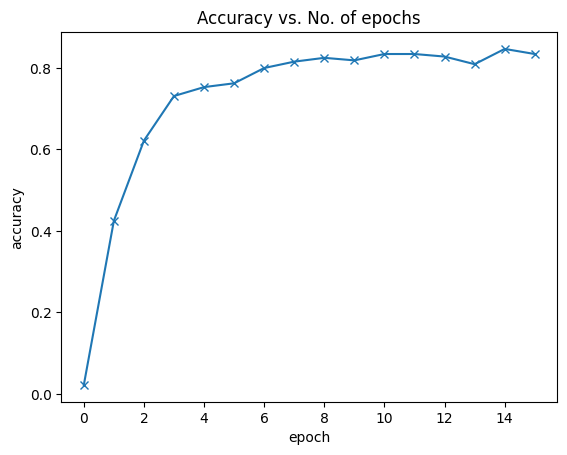

In [249]:
plot_accuracies(history)

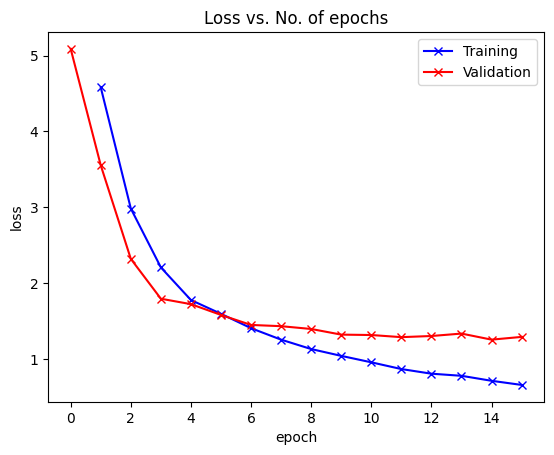

In [250]:
plot_losses(history)

In [251]:
evaluate(model, test_loader)

{'val_loss': 1.2289390563964844, 'val_acc': 0.8575949668884277}

## FLOPs

In [252]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.03G
